In [ ]:
from util import load_original_data
load_original_data(0.1, 0.1)

In [ ]:
from util import create_dataset
create_dataset('data/original_dataset_0.80_0.10_0.10',5000, down_sample=True)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pickle
import numpy as np
f1 = open('data/split_0.80_0.10_0.10_aug_to_2500_down_sample_True_instance0-9/train_data0', 'rb')
X_sequence_train, X_feature_train, X_image_train, Y_train = pickle.load(f1)
f1.close()
f2 = open('data/split_0.80_0.10_0.10_aug_to_2500_down_sample_True_instance0-9/val_data', 'rb')
X_sequence_val, X_feature_val, X_image_val, Y_val = pickle.load(f2)
f2.close()
f3 = open('data/split_0.80_0.10_0.10_aug_to_2500_down_sample_True_instance0-9/test_data', 'rb')
X_sequence_test, X_feature_test, X_image_test, Y_test = pickle.load(f3)
f3.close()

from keras.preprocessing.sequence import pad_sequences
X_sequence_train_paded = pad_sequences(X_sequence_train, dtype='float', padding='post', value = np.nan)
X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
# 先pad再预处理，因为pad可以把array的list转为ndarray

from util import preprocess
X_sequence_train_trimed = preprocess(X_sequence_train_paded)
X_sequence_val_trimed = preprocess(X_sequence_val_paded)
X_sequence_test_trimed = preprocess(X_sequence_test_paded)

def build_channel(data):
    X = []
    for image in data:
        X.append(image.reshape(128, 128, 1))
    return X
X_image_train = np.array(build_channel(X_image_train))
X_image_val = np.array(build_channel(X_image_val))
X_image_test = np.array(build_channel(X_image_test))
X_feature_train = np.array(X_feature_train)
X_feature_val = np.array(X_feature_val)
X_feature_test = np.array(X_feature_test)
Y_train = np.array(Y_train)-1 # 文件夹名从1开始但是标签从0开始
Y_val = np.array(Y_val)-1
Y_test = np.array(Y_test)-1

In [2]:
Y_train_one_hot = keras.utils.to_categorical(Y_train, num_classes=11)
Y_val_one_hot = keras.utils.to_categorical(Y_val, num_classes=11)
Y_test_one_hot = keras.utils.to_categorical(Y_test, num_classes=11)



In [34]:
print(X_feature_test[0])

[0.311632  0.4890012]


In [169]:


def multi_input_model(sequence_shape, image_shape, feature_shape, num_classes):

    sequence_inputs = keras.Input(shape=sequence_shape, name='sequence')
    masking_layer = layers.Masking(mask_value=0)
    x1 = masking_layer(sequence_inputs)
    x1 = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x1)
    x1 = layers.Bidirectional(layers.GRU(64))(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Dense(128, activation="relu")(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Dense(32, activation="relu")(x1)

    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=32, kernel_size=(16,16), strides=2, activation="relu", padding='same')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(8,8), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x2)

    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = layers.Dense(32, activation="relu")(feature_inputs)
    x3 = layers.Dense(32, activation="relu")(x3)

    x = layers.concatenate([x1, x2, x3])
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=[sequence_inputs, image_inputs, feature_inputs], outputs=outputs)
    return model

In [15]:
def rnn_with_feature(sequence_shape, feature_shape, num_classes):
    sequence_inputs = keras.Input(shape=sequence_shape, name='sequence')
    masking_layer = layers.Masking(mask_value=0)
    x1 = masking_layer(sequence_inputs)
    x1 = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x1)
    x1 = layers.Bidirectional(layers.GRU(64))(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Dense(128, activation="relu")(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Dense(32, activation="relu")(x1)

    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = feature_inputs
    x3 = layers.Dense(64, activation="relu")(x3)
    x3 = layers.Dense(32, activation="relu")(x3)

    x = layers.concatenate([x1, x3])

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=[sequence_inputs, feature_inputs], outputs=outputs)
    return model

In [153]:
def cnn(image_shape,  num_classes):
    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=32, kernel_size=(16,16), strides=2, activation="relu", padding='same')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(8,8), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(128, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer='l1')(x2)
    model = keras.Model(inputs=image_inputs, outputs=outputs)
    return model

In [29]:
def cnn_with_feature(image_shape, feature_shape, num_classes):
    
    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=32, kernel_size=(16,16), strides=2, activation="relu", padding='same')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(8,8), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x2)
    
    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(feature_inputs)
    x3 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x3)

    x = layers.concatenate([x2, x3])
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer='l1')(x)
    model = keras.Model(inputs=[image_inputs, feature_inputs], outputs=outputs)
    return model

In [16]:
# model = multi_input_model(sequence_shape=(None, 3), image_shape=(128, 128, 1), 
#                         feature_shape=(2,), num_classes=11)
model = rnn_with_feature(sequence_shape=(None, 3),feature_shape=(2,), num_classes=11)
# model = cnn_with_feature(image_shape=(128, 128, 1), feature_shape=(2,), num_classes=11)
# model = cnn(image_shape=(128, 128, 1), num_classes=11)
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    # loss="sparse_categorical_crossentropy",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    # metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    run_eagerly=False,
)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath='models/rnn_with_feature_test/model_{epoch}',
    save_freq='epoch'),
  keras.callbacks.TensorBoard(log_dir='models/rnn_with_feature_test/logs')
]

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
masking_4 (Masking)             (None, None, 3)      0           sequence[0][0]                   
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, None, 256)    102144      masking_4[0][0]                  
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 128)          123648      bidirectional_8[0][0]            
____________________________________________________________________________________________

2022-10-19 18:51:01.635132: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-19 18:51:01.635168: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-19 18:51:02.366142: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-19 18:51:02.366347: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
# X_train = {'sequence':X_sequence_train_trimed, 'image':X_image_train, 'feature':X_feature_train}
# X_val = {'sequence':X_sequence_val_trimed, 'image':X_image_val, 'feature':X_feature_val}
X_train = {'sequence':X_sequence_train_trimed, 'feature':X_feature_train}
X_val = {'sequence':X_sequence_val_trimed, 'feature':X_feature_val}
# X_train = {'image':X_image_train, 'feature':X_feature_train}
# X_val = {'image':X_image_val, 'feature':X_feature_val}
model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=50, 
        validation_data=(X_val, Y_val_one_hot), callbacks=callbacks)

Epoch 1/50
  1/860 [..............................] - ETA: 2:31:15 - loss: 2.4671 - acc: 0.0312

2022-10-19 18:51:28.554992: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-19 18:51:28.555032: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/860 [..............................] - ETA: 10:09 - loss: 6.1786 - acc: 0.0469  

2022-10-19 18:51:29.371411: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-19 18:51:29.374988: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-19 18:51:29.427715: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5921 callback api events and 5918 activity events. 
2022-10-19 18:51:29.529232: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-19 18:51:29.642772: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: models/rnn_with_feature_test/logs/train/plugins/profile/2022_10_19_18_51_29

2022-10-19 18:51:29.716676: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to models/rnn_with_feature_test/logs/train/plugins/profile/2022_10_19_18_51_29/dell-Precision-7920-Tower.trace.json.gz
2022-10-19 18:51:29.790610: I tensorflow/core/pro

215/860 [======>.......................] - ETA: 55s - loss: 2.3529 - acc: 0.2698

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_215/assets


430/860 [==============>...............] - ETA: 51s - loss: 2.0570 - acc: 0.3660

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_430/assets


645/860 [=====================>........] - ETA: 28s - loss: 1.8494 - acc: 0.4446

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_645/assets


860/860 [==============================] - ETA: 0s - loss: 1.7173 - acc: 0.5036

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1_860/assets


860/860 [==============================] - 169s 185ms/step - loss: 1.7173 - acc: 0.5036 - val_loss: 1.2924 - val_acc: 0.7016
Epoch 2/50
215/860 [======>.......................] - ETA: 51s - loss: 1.2179 - acc: 0.7375

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_215/assets


430/860 [==============>...............] - ETA: 49s - loss: 1.1850 - acc: 0.7507

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_430/assets


645/860 [=====================>........] - ETA: 27s - loss: 1.1567 - acc: 0.7661

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_645/assets


860/860 [==============================] - ETA: 0s - loss: 1.1314 - acc: 0.7777

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2_860/assets


860/860 [==============================] - 152s 177ms/step - loss: 1.1314 - acc: 0.7777 - val_loss: 1.0494 - val_acc: 0.8268
Epoch 3/50
215/860 [======>.......................] - ETA: 50s - loss: 1.0315 - acc: 0.8218

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_215/assets


430/860 [==============>...............] - ETA: 49s - loss: 1.0255 - acc: 0.8250

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_430/assets


645/860 [=====================>........] - ETA: 27s - loss: 1.0061 - acc: 0.8332

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_645/assets


860/860 [==============================] - ETA: 0s - loss: 0.9968 - acc: 0.8374

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3_860/assets


860/860 [==============================] - 155s 180ms/step - loss: 0.9968 - acc: 0.8374 - val_loss: 1.0772 - val_acc: 0.8360
Epoch 4/50
215/860 [======>.......................] - ETA: 51s - loss: 0.9280 - acc: 0.8600

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_215/assets


430/860 [==============>...............] - ETA: 50s - loss: 0.9255 - acc: 0.8597

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_430/assets


645/860 [=====================>........] - ETA: 27s - loss: 0.9244 - acc: 0.8605

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_645/assets


860/860 [==============================] - ETA: 0s - loss: 0.9190 - acc: 0.8623

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4_860/assets


860/860 [==============================] - 153s 178ms/step - loss: 0.9190 - acc: 0.8623 - val_loss: 0.9753 - val_acc: 0.8285
Epoch 5/50
215/860 [======>.......................] - ETA: 50s - loss: 0.8861 - acc: 0.8775

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_215/assets


430/860 [==============>...............] - ETA: 50s - loss: 0.8714 - acc: 0.8821

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_430/assets


645/860 [=====================>........] - ETA: 28s - loss: 0.8698 - acc: 0.8821

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_645/assets


860/860 [==============================] - ETA: 0s - loss: 0.8624 - acc: 0.8834

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5_860/assets


860/860 [==============================] - 155s 180ms/step - loss: 0.8624 - acc: 0.8834 - val_loss: 0.9590 - val_acc: 0.8324
Epoch 6/50
215/860 [======>.......................] - ETA: 51s - loss: 0.8272 - acc: 0.8938

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_215/assets


430/860 [==============>...............] - ETA: 50s - loss: 0.8185 - acc: 0.8972

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_430/assets


645/860 [=====================>........] - ETA: 27s - loss: 0.8208 - acc: 0.8965

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_645/assets


860/860 [==============================] - ETA: 0s - loss: 0.8144 - acc: 0.8982

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6_860/assets


860/860 [==============================] - 154s 179ms/step - loss: 0.8144 - acc: 0.8982 - val_loss: 0.8883 - val_acc: 0.8674
Epoch 7/50
215/860 [======>.......................] - ETA: 51s - loss: 0.7939 - acc: 0.9031

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_215/assets


430/860 [==============>...............] - ETA: 50s - loss: 0.7848 - acc: 0.9070

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_430/assets


645/860 [=====================>........] - ETA: 27s - loss: 0.7839 - acc: 0.9069

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_645/assets


860/860 [==============================] - ETA: 0s - loss: 0.7826 - acc: 0.9077

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7_860/assets


860/860 [==============================] - 155s 180ms/step - loss: 0.7826 - acc: 0.9077 - val_loss: 0.9683 - val_acc: 0.8265
Epoch 8/50
215/860 [======>.......................] - ETA: 51s - loss: 0.7604 - acc: 0.9211

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_215/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_215/assets


430/860 [==============>...............] - ETA: 49s - loss: 0.7558 - acc: 0.9212

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_430/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_430/assets


645/860 [=====================>........] - ETA: 28s - loss: 0.7582 - acc: 0.9187

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_645/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_645/assets


860/860 [==============================] - ETA: 0s - loss: 0.7559 - acc: 0.9188

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_860/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8_860/assets


860/860 [==============================] - 155s 180ms/step - loss: 0.7559 - acc: 0.9188 - val_loss: 1.0183 - val_acc: 0.8189
Epoch 9/50
 96/860 [==>...........................] - ETA: 1:00 - loss: 0.7299 - acc: 0.9313

KeyboardInterrupt: 

2022-10-19 19:14:41.877316: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-19 19:14:42.672580: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-19 19:14:42.683758: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-19 19:14:42.879094: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-19 19:14:42.945943: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

(11, 11)
Normalized confusion matrix
[[8.61111111e-01 0.00000000e+00 1.15740741e-02 6.71296296e-02
  2.31481481e-03 0.00000000e+00 9.25925926e-03 0.00000000e+00
  0.00000000e+00 4.39814815e-02 4.62962963e-03]
 [5.33333333e-03 8.98666667e-01 7.46666667e-02 0.00000000e+00
  1.06666667e-02 2.66666667e-03 8.00000000e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.00000000e-02 2.40000000e-01 6.20000000e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.00000000e-02 0.00000000e+00
  0.00000000e+00 2.00000000e-02 0.00000000e+00]
 [4.11764706e-01 0.00000000e+00 0.00000000e+00 5.88235294e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.06382979e-03 1.06382979e-03 0.00000000e+00 0.00000000e+00
  7.32978723e-01 5.00000000e-02 2.10106383e-01 5.31914894e-04
  0.00000000e+00 1.59574468e-03 2.65957447e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.66666667e-02 9.71111111e-01 2.2222222

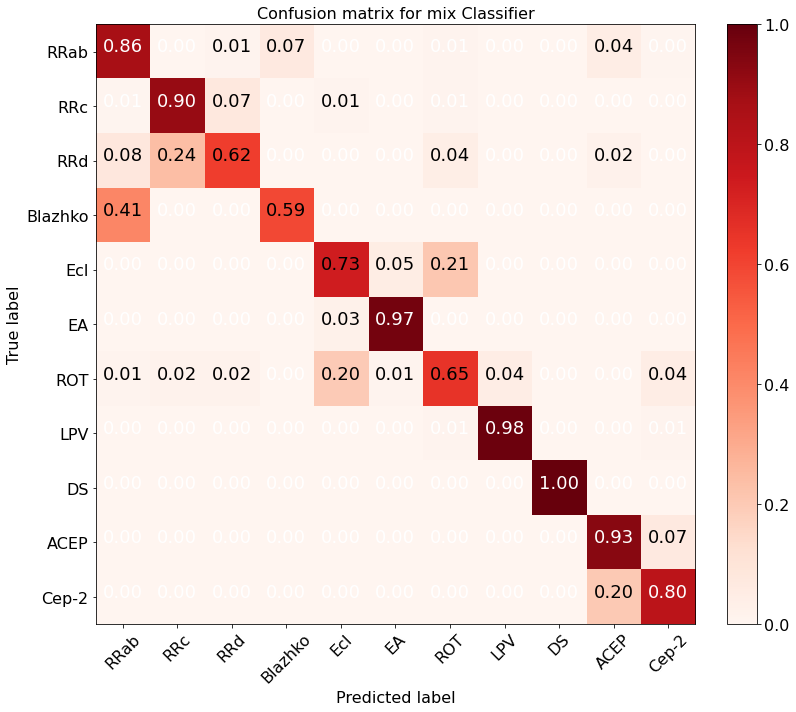

In [20]:
lodaed_model = keras.models.load_model('models/rnn_with_feature_test/model_5_430')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# from util import generate_batch

def generate_batch(X_sequence, X_image,  X_feature, Y, batch_size):
    idx = 0
    batch_num = len(Y)/batch_size
    while idx < batch_num:
        batch_x_sequence = X_sequence[idx * batch_size : (idx + 1) * batch_size]
        batch_x_image = X_image[idx * batch_size : (idx + 1) * batch_size]
        batch_x_feature = X_feature[idx * batch_size : (idx + 1) * batch_size]
        batch_y = Y[idx * batch_size : (idx + 1) * batch_size]
        yield batch_x_sequence, batch_x_image, batch_x_feature, batch_y
        idx += 1

test_gen = generate_batch(X_sequence_test_trimed, X_image_test, X_feature_test, Y_test, 128)      
y_label = Y_test

# train_gen = generate_batch(X_train_trimed, Y_train,128)      
# y_label = Y_train

y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
# for x, y in train_gen:
    y_predict = np.concatenate([y_predict, 
            np.argmax(lodaed_model.predict({'sequence':x_sequence, 
                                            # 'image':x_image,
                                            'feature':x_feature}), axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, normalize='true')
print(cm.shape)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(values_format='.2g')

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'ROT', 'LPV','DS','ACEP', 'Cep-2']

from util import cm_plot

plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=12,
                    cmap=plt.cm.Blues)